In [0]:
import numpy as np
import pandas as pd
import re, torch, time
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.utils.multiclass import unique_labels
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.utils.data
import copy

In [127]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cuda


In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
data = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/INF8111/data/preprocess.pkl")

Text(0.5, 1.0, 'Sequence length distribution')

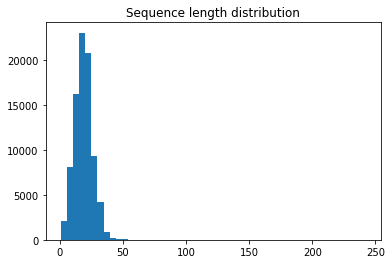

In [145]:
plt.hist([len(x) for x in data.tweet], bins=50)
plt.title("Sequence length distribution")

In [146]:
seq_len = 30
print("Mean sequence length: {:.2f}".format(np.array([len(x) for x in data.tweet]).mean()))
print("{:.2f}% of the samples are shorter than {}".format(100*len([len(x) for x in data.tweet if len(x)<=seq_len])/len(data), seq_len))

Mean sequence length: 19.07
95.09% of the samples are shorter than 30


In [0]:
def text2seq(X, y, vocab_max, seq_len, unk_tok='UNK', padd_tok='PAD' ):
  """ For a list of inputs X with different sequence length, associated to the labels y.
      Builds the list of the vocab_max-2 most common words. Maps each of them to a number.
      Replace the other words by the token unk_tok, which is mapped to the value 1.
      Then force the input to have a sequence length of seq_len with this policy:
        - If the sample x is short than seq_len, then adds padding at the begining.
          The padding token is set by the variable padd_tok. And mapped to the value 0.
        - If the sample x is longer than seq_len, then extracts (len(x)//seq_len)+1
          sequences from x.
  """
  count_words = Counter()
  for post in X:
    for tok in post:
      count_words[tok] += 1
  vocab = {w for w,_ in count_words.most_common(vocab_max-2)}.union( {unk_tok, padd_tok})
  word2val = {w : i+2 for i, (w,_) in enumerate( count_words.most_common(vocab_max-2) )}
  word2val[padd_tok] = 0
  word2val[unk_tok] = 1

  X2 = []
  y2 = []
  for i, x in enumerate(X):
    if len(x) < seq_len:
      tmp = x.copy()
      for _ in range(seq_len - len(x)):
        tmp.insert(0, padd_tok)
      X2.append([word2val[tok] if tok in vocab else 1 for tok in tmp])
      y2.append(y[i])
    elif len(x) == seq_len:
      X2.append([word2val[tok] if tok in vocab else 1 for tok in x]) 
      y2.append(y[i])
    else :
      for j in range(len(x)//seq_len):
        X2.append([word2val[tok] if tok in vocab else 1 for tok in  x[j*seq_len:(j+1)*seq_len]])
        y2.append(y[i])
      X2.append([word2val[tok] if tok in vocab else 1 for tok in  x[-seq_len:]])
      y2.append(y[i])
  return word2val, X2, y2

In [0]:
count = Counter()
for tweet in data.tweet.values:
  for tok in tweet:
    count[tok] += 1

In [149]:
seq_len = 30
hapax = [a for a in count if count[a] == 1]
print("Vocab_size: {}\t Hapax: {}\tVocab_withouthapax: {}".format(len(count), len(hapax), len(count) - len(hapax)))

Vocab_size: 63465	 Hapax: 37849	Vocab_withouthapax: 25616


In [0]:
vocab_max = len(count) # - len(hapax)
word2val, X, y = text2seq(data.tweet.values, data.label.values, vocab_max, seq_len) 

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5, random_state=42)
X_train = torch.tensor(X_train)
X_valid = torch.tensor(X_valid)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_valid = torch.tensor(y_valid)
y_test = torch.tensor(y_test)
train_data = torch.utils.data.TensorDataset(X_train, y_train)
valid_data = torch.utils.data.TensorDataset(X_valid, y_valid)
test_data = torch.utils.data.TensorDataset(X_test, y_test)

In [0]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=True, batch_size=batch_size)

In [0]:
class GRU(nn.Module):
    def __init__(self,
                 emb_size,
                 hidden_size,
                 vocab_size,
                 num_layers,
                 output_size,
                 nonlinearity = 'relu',
                 bias = True,
                 dropout = 0,
                 bidirectional = True
                ):
        super(GRU, self).__init__()
        #hyper-parameters
        self.emb_size      = emb_size
        self.hidden_size   = hidden_size
        self.vocab_size    = vocab_size
        self.num_layers    = num_layers
        self.output_size   = output_size
        self.nonlinearity  = nonlinearity
        self.bias          = bias
        self.dropout       = dropout
        self.bidirectional = bidirectional
        #layers
        self.embedding = nn.Embedding(vocab_size, emb_size).to(device)
        self.gru = nn.GRU(input_size = emb_size,
                          hidden_size = hidden_size,
                          num_layers = num_layers,
                          bias = bias,
                          dropout = dropout,
                          bidirectional = bidirectional
                         ).to(device)
        self.linear = nn.Linear((bidirectional+1) *hidden_size, output_size).to(device)
        
    def forward(self, X):
        out = self.embedding(X.t())
        out, _ = self.gru(out)
        return self.linear(out[-1])
    
    def predict(self, data):
        if isinstance(data, torch.utils.data.DataLoader):
            y = []
            for i in range((len(data.dataset)//data.batch_size)+1):
                imin = i*data.batch_size
                imax = min((i+1)*batch_size, len(data.dataset))
                y.append(self.forward(data.dataset[imin:imax][0].to(device)).max(dim=1)[1])
            return torch.cat(y)
        elif isinstance(data, torch.Tensor):
            return self.forward(data.to(device)).max(dim=1)[1]
        elif isinstance(data, torch.utils.data.dataset.TensorDataset):
            return self.predict(data.tensors[0])
        else:
            raise AttributeError("data must be an instance of DataLoader, Tensor or TensorDataset")
        

    def accuracy(self, X, y=None):
        if isinstance(X, torch.utils.data.DataLoader):
            return (self.predict(X) == X.dataset.tensors[1].to(device)).float().sum().item() / len(X.dataset.tensors[1])
        elif isinstance(X, torch.Tensor) and isinstance(y, torch.Tensor):
            return (self.predict(X.to(device)) == y.to(device)).float().sum().item() / len(y)
        else :
            raise AttributeError("Must be called with X as a DataLoader or X and y some Tensor")
    
    def f1_score(self, data_loader, label=1):
        return f1_score((data_loader.dataset[:][1] == label).int().cpu().numpy(),
                        (self.predict(data_loader) == label).int().cpu().numpy() )

    def run_epoch(self, n_epochs, criterion, optimizer, train_loader,
                  valid_loader=None, early_stop=True, patience=1 ):
        start_time = time.time()
        last_time = time.time()
        if valid_loader:
            best_score = -1
            best_param = None
            epochs_since_best_score = 0
        for epoch in range(1, n_epochs+1):
            print("Epoch: {}/{}".format(epoch, n_epochs))
            running_loss = 0
            for i, (X_batch, y_batch) in enumerate(train_loader):
                y_batch = y_batch.to(device)
                torch.cuda.empty_cache()
                optimizer.zero_grad()
                out = self.forward(X_batch.to(device))
                loss = criterion(out, y_batch)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            train_score = self.f1_score(train_loader, label=0)
            if valid_loader:
                valid_score = self.f1_score(valid_loader, label=0)
                print("loss: {:.6f}\ttrain_f1: {:.4f}\telapsed_time: {:.1f}s\tvalid_f1: {:.4f}".format(
                    running_loss/len(train_loader.dataset), train_score, time.time()-start_time, valid_score))
                if best_score > valid_score:
                    epochs_since_best_score +=1
                    if early_stop and epochs_since_best_score == patience:
                        print("Early stopping. Resetting the parameters of the\
                        best score on the validation set.")
                        self.load_state_dict(best_param)
                        return
                else:
                    best_score  = valid_score
                    best_param = copy.deepcopy(self.state_dict())
                    epochs_since_best_score = 0
            else:
                print("loss: {:.6f}\ttrain_f1: {:.4f}\telapsed_time: {:.1f}s".format(
                    running_loss/len(train_loader.dataset), train_score, time.time()-start_time))



In [0]:
model = 'GRU'
emb_size = 16
hidden_size = 64
num_layers = 8
output_size = 4
bidirectional=True
dropout = 0.5
filename = '{}{}_emb{}_hid{}_lay{}_vocab{}.pt'.format('bi' if bidirectional else '', model, emb_size, hidden_size, num_layers, vocab_max )


gru = GRU(emb_size = emb_size, hidden_size = hidden_size, vocab_size = vocab_max,
          num_layers = num_layers, output_size = output_size, bidirectional=bidirectional, dropout=dropout)

In [0]:
class_weight = compute_class_weight('balanced', np.unique(y_train.unique()), y_train.numpy())
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weight).to(device))
optimizer = torch.optim.Adam(gru.parameters(), weight_decay=10e-5)

In [215]:
gru.run_epoch(n_epochs=20, criterion=criterion, optimizer=optimizer, train_loader=train_loader, valid_loader=valid_loader, early_stop=True, patience=10)

Epoch: 1/10
loss: 0.008614	train_f1: 0.1110	elapsed_time: 115.1s	valid_f1: 0.1127
Epoch: 2/10
loss: 0.007272	train_f1: 0.1586	elapsed_time: 229.9s	valid_f1: 0.1455
Epoch: 3/10
loss: 0.006768	train_f1: 0.1852	elapsed_time: 345.2s	valid_f1: 0.1802
Epoch: 4/10
loss: 0.006417	train_f1: 0.2478	elapsed_time: 460.4s	valid_f1: 0.2132
Epoch: 5/10
loss: 0.006030	train_f1: 0.2346	elapsed_time: 575.4s	valid_f1: 0.2132
Epoch: 6/10
loss: 0.005637	train_f1: 0.3147	elapsed_time: 690.4s	valid_f1: 0.2736
Epoch: 7/10
loss: 0.005260	train_f1: 0.3701	elapsed_time: 805.2s	valid_f1: 0.3289
Epoch: 8/10
loss: 0.004936	train_f1: 0.3909	elapsed_time: 920.0s	valid_f1: 0.3098
Epoch: 9/10
loss: 0.004647	train_f1: 0.3986	elapsed_time: 1035.3s	valid_f1: 0.3014
Epoch: 10/10
loss: 0.004381	train_f1: 0.4009	elapsed_time: 1150.4s	valid_f1: 0.2961


In [216]:
print(classification_report(y_test.cpu().numpy(), gru.predict(test_loader).cpu().numpy()))

              precision    recall  f1-score   support

           0       0.19      0.67      0.30       654
           1       0.94      0.75      0.84      5284
           2       0.89      0.66      0.76      7386
           3       0.38      0.75      0.51      1425

    accuracy                           0.70     14749
   macro avg       0.60      0.71      0.60     14749
weighted avg       0.83      0.70      0.74     14749



In [0]:
y_true = y_test.cpu().numpy()
y_pred = gru.predict(test_loader).cpu().numpy()

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=[ 0,1,2,3, 3.5],
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    plt.title(title+'\n\n\n')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


Confusion matrix, without normalization
[[ 438   94  106   16]
 [1098 3976  183   27]
 [ 662  119 4894 1711]
 [  22   17  322 1064]]


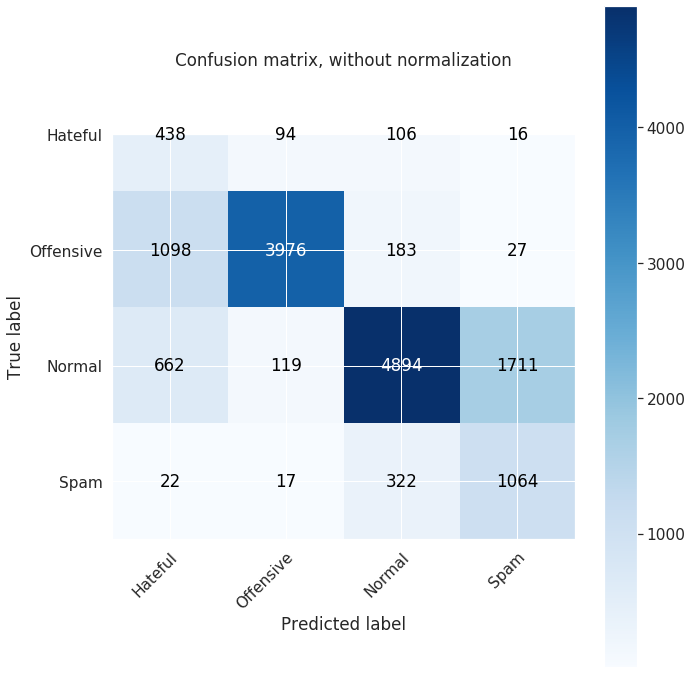

In [327]:
plot_confusion_matrix(y_true, y_pred, ['Hateful', 'Offensive', 'Normal', 'Spam'])